<a href="https://colab.research.google.com/github/ulissigroup/math-methods-chemical-engineering/blob/master/lecture_notes/13-numerical-solutions-to-ODEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
$$\newcommand{\arr}[1]{\underline{\underline{#1}}}$$    
$$\newcommand{\vec}[1]{\underline{#1}}$$   
$$\require{mhchem}$$

# Introduction to Numerical Solution of Differential Equations


* We'll start with simple $1^\circ$ ODE Initial Value Problem (IVP)
\begin{align}
\frac{dy}{dt} = -y, && y(t=0) = 1
\end{align}
We've solved this already
\begin{align}
y = \exp(-x)
\end{align}
* How would you do this without being able to solve differential equation? The Taylor expansion is a related concept, so let's quickly review that.



## Benefits of analytical/numerical methods

Analytical | Numerical
--- | ---
 \+ exact solution | - approximation to real solution
 \+ tells you which parameters are important | - black box
 \+ functional form (engineering insight) | - hard to check if answer is correct
 - very hard for complicated ODE's | - programming bugs
 - slow (can take days to work out solution) | \+ fast to implement
 - Algebra mistakes | \+ solve very hard equations
 - Still have to plot a solution at end | \+ good to solve engineering problems at specific set of parameters etc.
 \+ solve for all parameters

## Taylor expansions
* We have a complicated function (based on info at one point) that we want ot approximate. The Taylor series is a polynomial approxiamation of $f$:
\begin{align}
\hat{f} = a + bx + cx^2 + dx^3
\end{align}
The simplest approximation is $\hat{f} = a$. Let's demonstrate with $f(x) = \exp(x)$

* Each coefficient is obtained by matching derivatives
\begin{align}
\hat{f}(x=0) = a = f(x=0)\\
\frac{d\hat{f}}{dx}\bigg|_{x=0} = b = \frac{df}{dx}\bigg|_{x=0}\\
\frac{d^2\hat{f}}{dx^2}\bigg|_{x=0} = 2c = \frac{d^2}{dx^2}\bigg|_{x=0}
\end{align}
And so on..

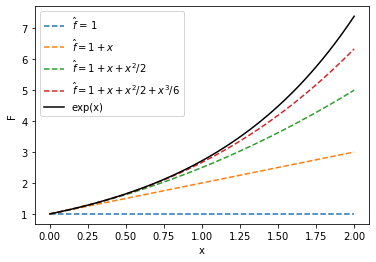

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2)
f1 = np.ones(len(x))
f2 = 1 + x
f3 = 1 + x + x**2 / 2
f4 = 1 + x + x**2 / 2 + x**3 / 6
f = np.exp(x)
plt.plot(x, f1, '--', label = '$\hat{f}$ = 1')
plt.plot(x, f2, '--', label = '$\hat{f} = 1 + x$')
plt.plot(x, f3, '--', label = '$\hat{f} = 1 + x + x^2 / 2$')
plt.plot(x, f4, '--', label = '$\hat{f} = 1 + x + x^2/2 + x^3/6$')
plt.plot(x, f, 'k', label = 'exp(x)')
plt.xlabel('x')
plt.ylabel('F')
plt.legend()
plt.show()

## Example of taylor expansion in python

Rather than explicitly coding the Taylor expansion, let's make a little function to do this for us. 

In [0]:
from scipy.special import factorial

def taylor_exp(x,N):
  # this function evaluates the taylor expansion of exp(x)

  # x is a range of x to evaluate at
  # N is the order of the taylor expansion

  y=0.0

  # Loop over N, adding terms 
  for n in range(N):
      y = y + x**n/factorial(n)

  # return the final approximation to y
  return y

#Test the function for x=2 at order 1    
taylor_exp(x=2,N=6)

7.266666666666667

Using this function, we plot the the curves from before.

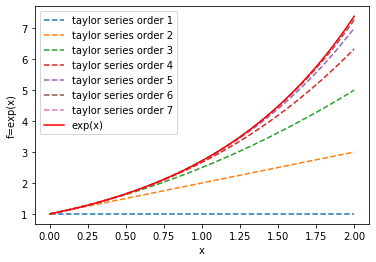

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Choose 100 points to evaluate
x = np.linspace(0,2,100)

# For each order 1 to 5, compute teh approximation and plot
for n in range(1,8):
  plt.plot(x,taylor_exp(x,n),'--', label='taylor series order %d'%n)

# Plot the known (analytical exp(x) ) expression
plt.plot(x,np.exp(x),'r',label='exp(x)')

# Add x/y labels and legend
plt.xlabel('x')
plt.ylabel('f=exp(x)')
plt.legend()

There's even a scipy function that will estimate the polynomial terms in the Taylor expansion at a point for an arbitrary function!

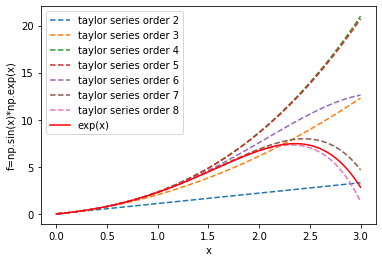

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import approximate_taylor_polynomial 

# Choose 100 points to evaluate
x = np.linspace(0,3,100)

def myfunc(x):
  return np.sin(x)*np.exp(x)

# For each order 1 to 5, compute teh approximation and plot
for n in range(1,8):
  p = approximate_taylor_polynomial(myfunc, 0, n, scale=0.1)
  plt.plot(x,np.polyval(p, x),'--', label='taylor series order %d'%(n+1))

# Plot the known (analytical exp(x) ) expression
plt.plot(x,myfunc(x),'r',label='exp(x)')

# Add x/y labels and legend
plt.xlabel('x')
plt.ylabel('f=np.sin(x)*np.exp(x)')
plt.legend()

The Taylor expansion is an approximation to the true solution. Clearly, the answer at $x=2$ gets better as the order of the approximation increases. Let's plot the difference between the true solution and the approximation for various order n

Text(0, 0.5, 'Error in Taylor approx, abs[f(x=2)-exp(x=2)]')

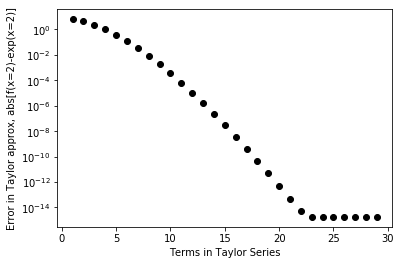

In [0]:
x=2
for n in range(1,30):
  #Calculate the difference between the true solution and approximate solution at x=2
  error = np.abs(np.exp(x)-taylor_exp(x,n))

  #plot the error
  plt.semilogy(n,error,'ok')

# add x/y labels
plt.xlabel('Terms in Taylor Series')
plt.ylabel('Error in Taylor approx, abs[f(x=2)-exp(x=2)]')

* Notice how the error gets smaller and smaller as the number of points goes. 

* However, this only works so far, and eventually the error saturates. This is because of how numbers are stored in a computer. Floating point numbers are stored as (on a 32-bit computer):
\begin{align}
1.362597134568123 \times 10^{+36} && \text{(15 decimal places and power of 10)}
\end{align}
* Since there's only 16 demical places, we can't really get any more accurate than that. 




## Euler's Method

* Simplest possible scheme - use the Taylor expansion to move from one point to the next for integrating. Start with definition of derivative:
\begin{align}
\frac{dy}{dt}\bigg|_{t=0} = \frac{y(t=h) - y(t=0)}{h - 0}\\
\frac{dy}{dt}\bigg|_{t=0} = \frac{y(t_1) - y(t_0)}{t_1 - t_0}
\end{align}
Let's rearrange
\begin{align}
y(t_1) = \frac{dy}{dt}\bigg|_{t_0}(t_1-t_0) + y(t_0) \ \rightarrow \text{  ODE gives us this!}
\end{align}
$\underline{\text{Ex}}$ : $\frac{dy}{dt} = - y$,  $\hspace{1cm}y(t=0) = 1$
\begin{align}
y(t&=0) = 1\\
y(t_1) &= \frac{dy}{dt}\bigg|_{t=0} (t_1 - 0) + y(t = 0)\\
&= -y \bigg|_{t=0}t_1 + 1
\end{align}
Evaluate error for Euler approximation
\begin{align}
y(t) = \exp(-t) \leftarrow \text{  known}\\
y(\Delta t) = y(0) + \Delta t \frac{dy}{dt}\bigg|_{t=0} + \frac{\Delta t^2}{2} \frac{d^2y}{dt^2}\bigg|_{t=0} + ...\\
\frac{y(\Delta t) - y(0)}{\Delta t} = \frac{dy}{dt}\bigg|_{t=0} + \frac{\Delta t}{2} \frac{d^2y}{dt^2}\bigg|_{t=0} + ...
\end{align}
We are neglecting the second order terms and beyond. Error decays proportional to $\Delta t$!


## Example: integrate to t=2 for $y'=-y$ using this method. 

## Implementation of Euler's method in python

First, let's define a function that represents what we want to integrate, of the form $y'=F(t,y)$

In [0]:
# Define the function we want to integrate
def yprime(t,y):
  return -y

# try y' at t=0, y=1
yprime(1/2,1/2)

-0.5

Now, we will write a function that loops through a range of times, and keeps adding the slope each time. 

In [0]:
def euler_integrate(func, t, y0):
  # func: the function to integrate, of the form
  #       y'=F(t,y)
  # y0:   the initial function value
  # t:    the range of times to evaluate

  y = [y0]
  dt = t[1]-t[0]

  #Loop through and implement the update
  for new_time in t[1:]:

    # current y
    current_y = y[-1]

    #Get the current derivative
    yprime=func(t,current_y)

    #Update y, fill this in
    updated_y = yprime*dt + current_y

    #Save the y
    y.append(updated_y)

  return y


Let's test this function for a step size of 0.5

Text(0, 0.5, 'y')

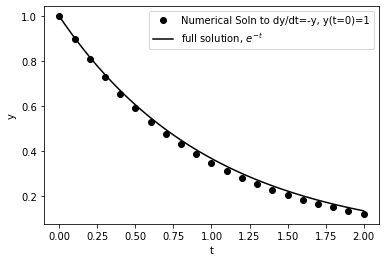

In [0]:
# Generate a range of t from 0 to 2, with a timestep of 0.5
t = np.arange(0,2.1,0.1)

# Use or ne function
y = euler_integrate(yprime, t, 1)

#Plot the results
plt.plot(t,y,'ok', label='Numerical Sol''n to dy/dt=-y, y(t=0)=1')
plt.xlabel('t')
plt.ylabel('Numerical Sol''n to dy/dt=-y, y(t=0)=1')

t=np.linspace(0,2,100)

plt.plot(t,np.exp(-t),'k-', label='full solution, $e^{-t}$')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')

Let's play around with the step size and see how the error at t=2 changes

In [0]:
t = np.arange(0,2.01,0.0001)
y = euler_integrate(yprime, t, 1)

print('Error of f(x=2) = %f'%abs(y[-1]-np.exp(-t[-1])))

Error of f(x=2) = 0.000013


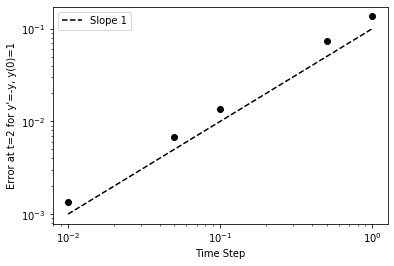

In [0]:
# Scan over a range of time steps

for dt in [1,.5,.1,.05,.01]:

  # Calculate the solution
  t = np.arange(0,2.01,dt)
  y = euler_integrate(yprime, t, 1)

  # Plot the error (difference beteween analytical 
  # solution and numerical solution)
  plt.loglog(dt,abs(y[-1]-np.exp(-t[-1])),'ok')

# Plot a simple -1 log scaling to show the error drops
dt=np.logspace(-2,0);
plt.plot(dt,dt/10,'k--',label='Slope 1')

plt.xlabel('Time Step')
plt.ylabel('Error at t=2 for y\'=-y, y(0)=1')
plt.legend()

# Euler's method with second derivatives

We truncated the approximation at the first derivative in the Euler scheme. An obvious question is whether using the second derivative would improve things?

For example, let's propose a new method:
\begin{align}
y(t) - y(t_0) = \Delta t \frac{dy}{dt}\bigg|_{t = t_0} + \frac{\Delta t^2}{2} \frac{d^2y}{dt^2}\bigg|_{t = t_0}
\end{align}
We have a new term, if we know $\frac{d^2y}{dt^2}\bigg|_{t=t_0}$. Now the order should be better as $\Delta t^2$

### Example with second order
$y(t_1) = -t + 1$\
or more generally:
\begin{align}
y(t_1) = -y (t_0) (t_1 - t_0) + y(t_0)
\end{align}
Remember, this only really holds for $t_1 - t_0 \rightarrow 0$

<img src="https://docs.google.com/drawings/d/e/2PACX-1vSgJC6gobNTNfiWxOfOGH1RhSYBz1tefW9Nbmbdul4yPxR7FZjQBe1bfFgy_SaWqiYI6c4Y7nwg2ryw/pub?w=558&h=283">

## Python implementation of the second order Euler method

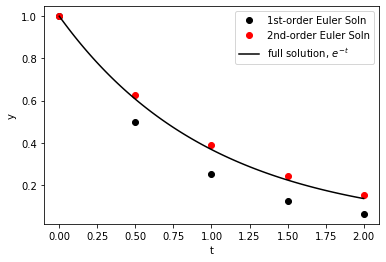

In [0]:
# Define the function we want to integrate
def yprime_yprimeprime(t,y):
  #return y', y''
  return -y, y

def euler_2nd_derivative_integrate(func, t, y0):

  y = [y0]
  current_time = t[0]
  dt = t[1]-t[0]

  #Loop through and implement the update
  for new_time in t[1:]:

    current_y = y[-1]

    #Get the current derivative
    yprime, yprimeprime=func(t,current_y)

    #Find the current step size
    updated_y = current_y + dt*yprime + dt**2/2*yprimeprime

    #Save the y
    y.append(updated_y)

  return y

t = np.arange(0,2.1,0.5)
y = euler_integrate(yprime, t, 1)
plt.plot(t,y,'ok', label='1st-order Euler Sol''n')

y = euler_2nd_derivative_integrate(yprime_yprimeprime, t, 1)
plt.plot(t,y,'or', label='2nd-order Euler Sol''n')

t = np.linspace(0,2,100)
plt.plot(t,np.exp(-t),'k-', label='full solution, $e^{-t}$')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()



Let's see how accurate this new method is with respect to step size!

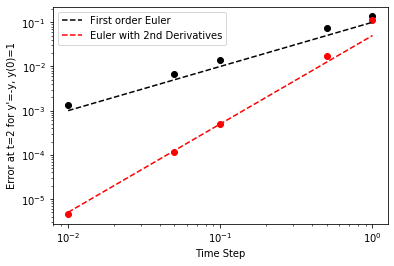

In [0]:
# Scan over a range of time steps

for dt in [1,.5,.1,.05,.01]:

  # Calculate the solution
  t = np.arange(0,2.01,dt)
  y = euler_integrate(yprime, t, 1)

  # Plot the error (difference beteween analytical 
  # solution and numerical solution)
  plt.loglog(dt,abs(y[-1]-np.exp(-t[-1])),'ok')

  # Calculate the solution
  t = np.arange(0,2.01,dt)
  y = euler_2nd_derivative_integrate(yprime_yprimeprime, t, 1)

  # Plot the error (difference beteween analytical 
  # solution and numerical solution)
  plt.loglog(dt,abs(y[-1]-np.exp(-t[-1])),'or')

# Plot a simple -1 log scaling to show the error drops
dt=np.logspace(-2,0);
plt.plot(dt,dt/10,'k--',label='First order Euler')

dt=np.logspace(-2,0);
plt.plot(dt,dt**2./20,'r--', label='Euler with 2nd Derivatives')


plt.xlabel('Time Step')
plt.ylabel('Error at t=2 for y\'=-y, y(0)=1')
plt.legend()


## Mid-point method

* So, we have a method that allows us to integrate forward as long as our step size is small enough. However, we want the step size to be large to keep our method fast. What can we do to improve this?

* We showed an example of a second order method if we know the second derivative to help in our Taylor series. We can so similarly well with other schemes.

<img src="https://docs.google.com/drawings/d/e/2PACX-1vRnHTAakWpLwYKmHHkSQtfEcBe9IYZse9Sz3DLt5paAkwYClrhBRzp88uAr4BxIFrn_2qA5YYmOhOhj/pub?w=460&amp;h=808">

The problem here is that $\frac{dy}{dt}\bigg|_{t=0}$ is not a good approximation everywhere in the interval and expectedly at the end. So, let's make a better approximation. Let's take a step half way across the interval using the first approximation.
\begin{align}
y(\Delta t) = y(0) + \Delta t \frac{dy}{dt} \bigg|_{t = \frac{\Delta t}{2}}\\
\frac{dy}{dt}\bigg|_{t = \frac{\Delta t}{2}} = \frac{dy}{dt}\bigg|_{t=0} + \left( \frac{\Delta t}{2}\right) \frac{d^2y}{dt^2}\bigg|_{t=0} + \frac{1}{2} \left( \frac{\Delta t}{2}\right)^2 \frac{d^3y}{dt^3}\bigg|_{t=0} + ...\\
y(\Delta t) = y(t=0) + \Delta t \left(\frac{dy}{dt}\bigg|_{t=0} + \frac{\Delta t}{2} \frac{d^2}{dt^2}\bigg|_{t=0} + ... \right)
\end{align}
Last full term is the approximation of mid-point slope. Thus, mid-point method is an $O(\Delta t^2)$ method without using any information from the second derivative. Proposed process:
\begin{align}
y_{N+\frac{1}{2}} = y_N + \frac{\Delta t}{2} \frac{dy}{dt}\bigg|_N\\
y_{N+1} = y_N + \Delta t \frac{dy}{dt}\bigg|_{N+\frac{1}{2}}
\end{align}
$\underline{\text{Ex}}$:  $\frac{dy}{dt} = -y, \hspace{1cm} y(t=0)=1$
\begin{align}
y_{N+\frac{1}{2}} = 1 + \frac{\Delta t}{2} \frac{dy}{dt}\bigg|_{t=0} = 1 - \frac{\Delta t}{2}\\
y_{N+1} = 1 + \Delta t \left(- \left(1 - \frac{\Delta t}{2} \right) \right) = 1 - \Delta t \left(1 - \frac{\Delta t}{2} \right) 
\end{align}

## Python implementation of the mid-point method




In [0]:
def midpoint_integrate(func, t, y0):
  # func: the function to integrate, of the form
  #       y'=F(t,y)
  # y0:   the initial function value
  # t:    the range of times to evaluate

  y = [y0]
  dt = t[1]-t[0]

  #Loop through and implement the update
  for new_time in t[1:]:

    current_y = y[-1]

    #Get the current derivative
    yprime=func(t,current_y)

    #Get the mid-point
    yN12= current_y + yprime * dt/2

    #Get the derivative at the mid-point
    yprimeN12= func(t+dt/2, yN12) # fill this in

    #Take the full step
    updated_y= current_y + dt*yprimeN12 # fill this in

    #Save the y
    y.append(updated_y)

  return y


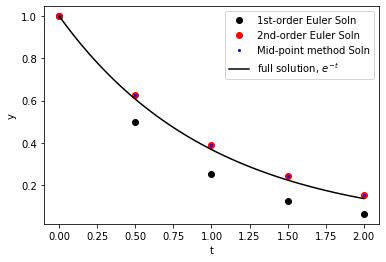

In [0]:
t = np.arange(0,2.1,0.5)
y = euler_integrate(yprime, t, 1)
plt.plot(t,y,'ok', label='1st-order Euler Sol''n')

y = euler_2nd_derivative_integrate(yprime_yprimeprime, t, 1)
plt.plot(t,y,'or', label='2nd-order Euler Sol''n')

y = midpoint_integrate(yprime, t, 1)
plt.plot(t,y,'ob', markersize=2, label='Mid-point method Sol''n')

t = np.linspace(0,2,100)
plt.plot(t,np.exp(-t),'k-', label='full solution, $e^{-t}$')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()


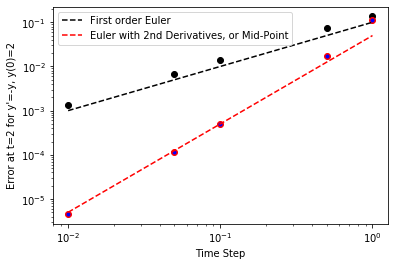

In [0]:
# Scan over a range of time steps

for dt in [1,.5,.1,.05,.01]:

  # Calculate the solution
  t = np.arange(0,2.01,dt)
  y = euler_integrate(yprime, t, 1)

  # Plot the error (difference beteween analytical 
  # solution and numerical solution)
  plt.loglog(dt,abs(y[-1]-np.exp(-t[-1])),'ok')

  # Calculate the solution
  y = euler_2nd_derivative_integrate(yprime_yprimeprime, t, 1)

  # Plot the error (difference beteween analytical 
  # solution and numerical solution)
  plt.loglog(dt,abs(y[-1]-np.exp(-t[-1])),'or')

  # Calculate the solution
  y = midpoint_integrate(yprime, t, 1)

  # Plot the error (difference beteween analytical 
  # solution and numerical solution)
  plt.loglog(dt,abs(y[-1]-np.exp(-t[-1])),'ob', markersize=3)

# Plot a simple -1 log scaling to show the error drops
dt=np.logspace(-2,0);
plt.plot(dt,dt/10,'k--',label='First order Euler')

dt=np.logspace(-2,0);
plt.plot(dt,dt**2./20,'r--', label='Euler with 2nd Derivatives, or Mid-Point')


plt.xlabel('Time Step')
plt.ylabel('Error at t=2 for y\'=-y, y(0)=2')
plt.legend()

## Final Method: Runge-Kutta

* There are many possible ways to approximate these differential equations. Euler and mid-point are very simple and not widely used in practice. 
* Which method you use depends on your problem and limitations/constraints. 
* The Runge-Kutta method works very well and is widely used in practice, and is a reasonable trade-off in Order, complexity, speed etc. This is an $O(\Delta t^4)$ method - extemely powerful.\
Def:
\begin{align}
k_1 &= \Delta t \cdot f(t^N, y^N)\\
k_2 &= \Delta t \cdot f\left(t^N+\frac{\Delta t}{2}, y^N + \frac{k_1}{2}\right)\\
k_3 &= \Delta t \cdot f\left(t^N+\frac{\Delta t}{2}, y^N + \frac{k_2}{2}\right)\\
k_4 &= \Delta t \cdot f(t^N+\Delta t, y^N + k_3)\\
y^{N+1} &= y^N + \frac{k_1}{6} + \frac{k_2}{3} + \frac{k_3}{3} +  \frac{k_4}{6}
\end{align}
Very similar to ODE45 in Matlab


# Numerical integration in scipy

* scipy contains a well-rounded ODE integration method ``scipy.integrate.solve_ivp``. It works pretty much the same as the other methods we've seen in terms of functional form. Linke here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
* The only additional trick is that this method can figure out a reasonable guess for the step size



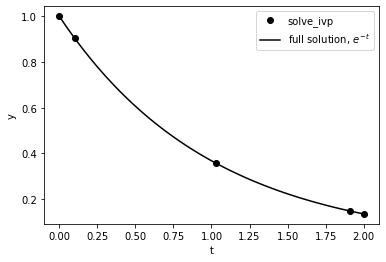

In [0]:
from scipy.integrate import solve_ivp

def yprime(t,y):
  return -y

sol = solve_ivp(yprime, [0,2], [1])

plt.plot(sol.t,sol.y[0,:],'ok',label='solve_ivp')

t = np.linspace(0,2,100)
plt.plot(t,np.exp(-t),'k-', label='full solution, $e^{-t}$')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()


We can also do the same thing and get it to evaluate at a bunch of points. 

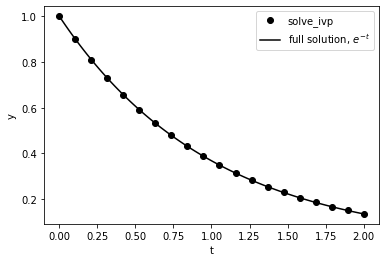

In [0]:
from scipy.integrate import solve_ivp

def yprime(t,y):
  return -y

t = np.linspace(0,2,20)

sol = solve_ivp(yprime, [0,2], [1], t_eval=t)

plt.plot(sol.t,sol.y[0,:],'ok',label='solve_ivp')

t = np.linspace(0,2,100)
plt.plot(t,np.exp(-t),'k-', label='full solution, $e^{-t}$')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()


* The solve_ivp documentation has some nice comments for what to do it things go wrong:

``If not sure, first try to run ‘RK45’. If it makes unusually many iterations, diverges, or fails, your problem is likely to be stiff and you should use ‘Radau’ or ‘BDF’. ‘LSODA’ can also be a good universal choice, but it might be somewhat less convenient to work with as it wraps old Fortran code``




### Higher order example

Notice that we haven't really discussed any higher-order examples, just first order differential equations. We can solve higher order differential equations using a little trick. We haven'y really talked about systems of differential equations, but let's take a little detour based no the notes from Tuesday. 

We're interested in trying to solve $$y''+2y'-3y=0, y(0)=1, y'(0)=4$$. A system of differential equations is (which we'll discuss in more detail later) is:
\begin{align}
\vec{y} = \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}&& \vec{y}' = \begin{bmatrix} y_1' \\ y_2'  \end{bmatrix} 
\end{align}
For a second order differential equation, let's say $y_1=y$ and $y_2=y'$. That leaves:
\begin{align}
\vec{y} = \begin{bmatrix} y\\y' \end{bmatrix}&& \vec{y}' = \begin{bmatrix} y' \\ y''  \end{bmatrix} 
\end{align}
We can use the ODE to substitute for the y'' assuming we can re-arrange correctly.
\begin{align}
\vec{y} = \begin{bmatrix} y\\y' \end{bmatrix}&& \vec{y}' = \begin{bmatrix} y' \\ 3y-2y'  \end{bmatrix}&&\vec{y}(t=0) = \begin{bmatrix} 1\\4  \end{bmatrix} 
\end{align}

We can easily solve this with ``solve_ivp``. 

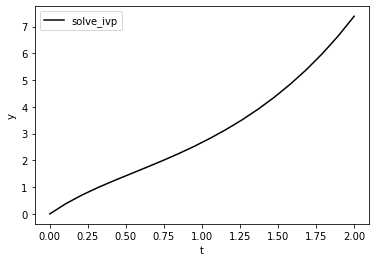

In [0]:
def second_order_yprime(t, y_vec):
  # t is the same t as before
  # y_vec is now a vector of y, y'

  y, yprime = y_vec

  return [yprime, 
          3*y-2*yprime]

t = np.linspace(0,2,20)

y_vec_initial = [0,4]

sol = solve_ivp(second_order_yprime, [0,2], y_vec_initial, t_eval=t)

plt.plot(sol.t,sol.y[0,:],'k-',label='solve_ivp')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()


# In-class example



Solve the system $$y''+0.5y'+y=0, y(0)=3,y'(0)=4$$

Note that this system has complex roots to the characteristic equation!

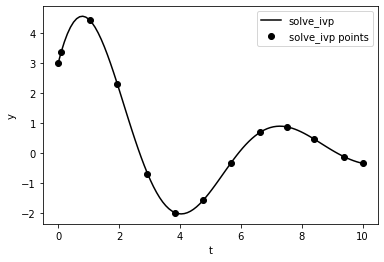

In [0]:
def second_order_yprime(t, y_vec):
  # t is the same t as before
  # y_vec is now a vector of y, y'

  y, yprime = y_vec

  return [ yprime, # fill this in, first derivative of y, 
          -0.5*yprime-y] # fill this in, second derivative of y

t = np.linspace(0,10,100)

y_vec_initial = [3,4]

sol = solve_ivp(second_order_yprime, [0,10], y_vec_initial, t_eval=t)


plt.plot(sol.t,sol.y[0,:],'k-',label='solve_ivp')

sol = solve_ivp(second_order_yprime, [0,10], y_vec_initial)

plt.plot(sol.t,sol.y[0,:],'ko',label='solve_ivp points')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()


## Practical tips:
* Very important to check whether the answer is reasonable
* If you solve a problem with $\Delta t = 0.1$ (or some other number), always check that your answer does not change with $\Delta t = \frac{0.1}{2}$
* Before solving a problem with numerical methods, make sure you can correctly code the RHS of the equation.
* If you are getting strange results, try a stiff solver instead. See the notes in t